In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as smf
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# IMPORT DATA FROM CSV
data = pd.read_csv("C:/Users/rdeterman/Desktop/CA_clean.csv")
df = data
data = data.drop(columns=['RM'])
data.head()
df.head()

,centerdate,RM,CA,TP,TN,prcpavg_73,tavg_57,basin,pred_h2o_temp
0,-4072.304393,78.4,21.80,0.074957,1.638819,-0.168401,12.133333,1,26.186955
1,-4072.304393,76.3,33.20,0.091993,1.638819,-0.168401,12.133333,1,26.186955
2,-4072.304393,74.3,43.40,0.101595,1.946973,-0.168401,12.133333,1,26.186955
3,-4072.304393,69.3,10.55,0.083475,1.218609,-0.168401,12.133333,0,26.186955
4,-4072.304393,66.2,18.80,0.060399,0.928664,-0.168401,12.133333,0,26.186955


# Looking at the correlation between variables
1. Correlation heat map 
2. Pair plot 

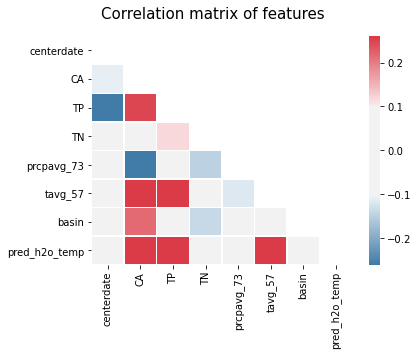

In [3]:
corr = data.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.26,
            vmax=0.26, center=0, linewidths=.5)

fig.suptitle('Correlation matrix of features', fontsize=15)
# ax.text(0.77, 0.2, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#     transform=ax.transAxes, color='grey', alpha=0.5)

fig.tight_layout()
# print(corr)

In [4]:
#sns.set(style="ticks", color_codes=True)
#g = sns.pairplot(data)

# Quantile Regression  CA over time 
https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

In [5]:
# CREATE MODEL AND FIT IT, RETURN THE QUANTILE, INTERCEPT, SLOPE, AND CONFICENCE INTERVAL
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['centerdate']] + \
        res.conf_int(alpha=0.005).loc['centerdate'].tolist()

In [6]:
# QR OF MEDIAN
mod = smf.quantreg('CA ~ 1 + centerdate ', data)
res = mod.fit(q=.5)
print(res.summary())
print(res.conf_int(alpha=0.005))

                         QuantReg Regression Results                          
Dep. Variable:                     CA   Pseudo R-squared:             0.005937
Model:                       QuantReg   Bandwidth:                       2.613
Method:                 Least Squares   Sparsity:                        8.785
Date:                Mon, 10 Aug 2020   No. Observations:                  955
Time:                        14:01:27   Df Residuals:                      953
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2498      0.142     22.863      0.000       2.971       3.529
centerdate    -0.0003   5.96e-05     -4.721      0.000      -0.000      -0.000

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [7]:
quantiles = np.array([0.01, 0.25, 0.5, 0.75, 0.90, 0.91,
                      0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'ub', 'lb'])


# OLS TO COMPARE FIT
ols = smf.ols('CA ~ 1 + centerdate', data).fit()
ols_ci = ols.conf_int(alpha=0.005).loc['centerdate'].tolist()
ols = dict(a=ols.params['Intercept'],
           b=ols.params['centerdate'],
           ub=ols_ci[0],
           lb=ols_ci[1])
print('Quantile Regression Models')
print(models)

Quantile Regression Models
       q          a         b        ub        lb
0   0.01   0.501691 -0.000033 -0.000069  0.000002
1   0.25   1.666361 -0.000122 -0.000230 -0.000014
2   0.50   3.249817 -0.000282 -0.000449 -0.000114
3   0.75   9.101912 -0.000855 -0.001430 -0.000280
4   0.90  22.133760 -0.002359 -0.003927 -0.000792
5   0.91  22.523423 -0.002392 -0.003898 -0.000886
6   0.92  24.242857 -0.001967 -0.003652 -0.000283
7   0.93  26.283433 -0.002214 -0.004405 -0.000023
8   0.94  28.752446 -0.002086 -0.004570  0.000399
9   0.95  31.289309 -0.002468 -0.004841 -0.000095
10  0.96  36.611608 -0.001667 -0.005170  0.001836
11  0.97  42.322422 -0.001429 -0.004912  0.002055
12  0.98  50.153079 -0.001095 -0.004441  0.002251
13  0.99  62.684860 -0.003976 -0.007592 -0.000359


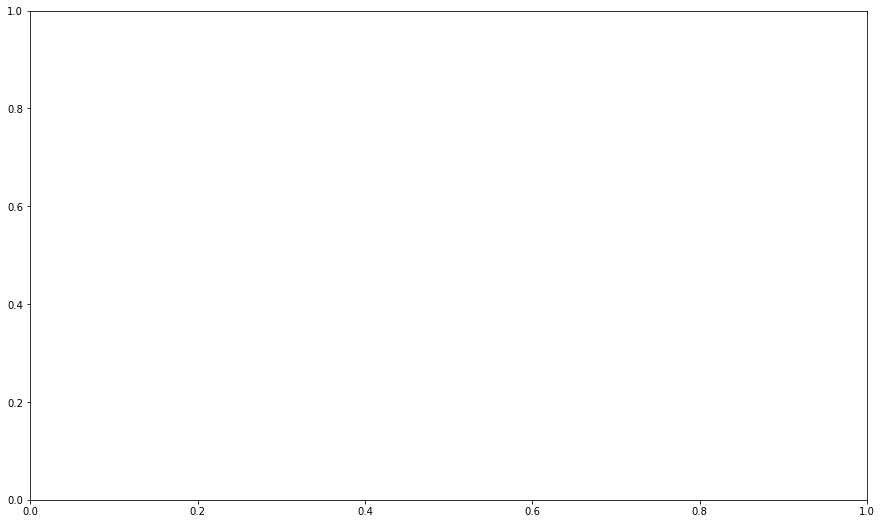

In [8]:
# PLOTTING THE QUANTILE REGRESSION RESULTS WITH SHADED CONFIDENCE INTERVAL
x = np.arange(data.centerdate.min(), data.centerdate.max())
def get_y(a, b): return a + b * x


fig, ax = plt.subplots(figsize=(15, 9))
plotq = np.array([1, 2, 3, 4, 8, 9, 10, 11, 12, 13])

# for i in range(models.shape[0]):
#for i in plotq:  # range(4,10):
#    y = get_y(models.a[i], models.b[i])
#    ax.plot(x, y, color='black')

# for i in range(models.shape[0]):
#for i in plotq:  # range(4,10):
#    y_1 = get_y(models.a[i], models.lb[i])
#    y_2 = get_y(models.a[i], models.ub[i])
#    plt.fill_between(x, y_2, y_1,
#                     color='orange',       # The outline color
#                     alpha=0.2)            # Transparency of the fill

#ax.scatter(data.centerdate, data.CA, alpha=.2)
#ax.set_xlim((-4000, 4000))
#ax.set_ylim((0, 100))

#ax.set_xlabel('centerdate', fontsize=16)
#ax.set_ylabel('CA', fontsize=16)
#print('quantiles')
#print(models.q[plotq])

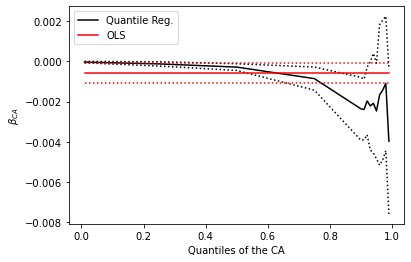

In [9]:
# COMPARING SLOPE OF QUANTILE REGRESSION VS OLS
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{CA}$')
plt.xlabel('Quantiles of the CA')
plt.legend()
plt.show()

# dotted black lines form 95% point-wise confidence band around 10 quantile regression estimates (solid black line).
# The red lines represent OLS regression results along with their 95% confidence interval.

# Quantile Regression TP over time 

Text(0, 0.5, 'TP')

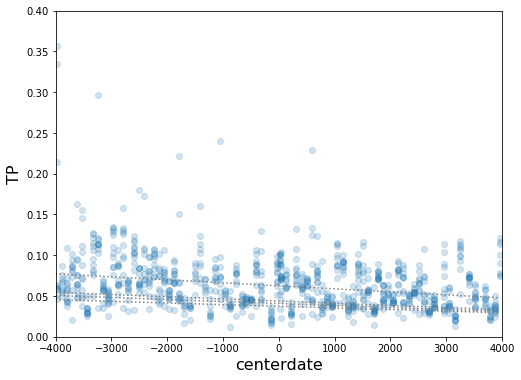

In [10]:
quantiles = np.arange(.10, 1, .05)

mod = smf.quantreg(' TP  ~ 1 + centerdate ', data)
print(mod)
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'ub', 'lb'])

#print('Quantile Regression Models')
# print(models)

x = np.arange(data.centerdate.min(), data.centerdate.max())

plotq = np.array([1, 2, 3,9])

fig, ax = plt.subplots(figsize=(8, 6))
for i in plotq:
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

ax.scatter(data.centerdate, data.TP, alpha=.2)
ax.set_xlim((-4000, 4000))
ax.set_ylim((0, 0.4))
ax.set_xlabel('centerdate', fontsize=16)
ax.set_ylabel('TP', fontsize=16)

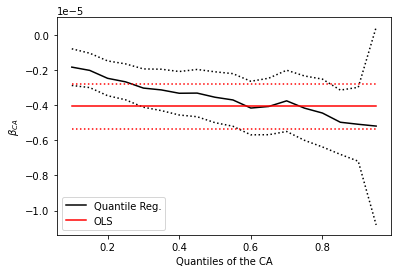

In [11]:
ols = smf.ols('TP ~ 1 + centerdate', data).fit()
ols_ci = ols.conf_int(alpha = 0.005).loc['centerdate'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['centerdate'],
           ub = ols_ci[0],
           lb = ols_ci[1])
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{CA}$') 
plt.xlabel('Quantiles of the CA')
plt.legend()
plt.show()

# OLS Regression

In [12]:
# CREATING THE ORDINARY LEAST SQUARES REGRESSION AND FITTING IT TO THE DATA
results = smf.ols(
    'CA ~ TP + TN + basin + tavg_57 + prcpavg_73', data=data).fit()
print(results.summary())
ci = smf.ols

                            OLS Regression Results                            
Dep. Variable:                     CA   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     56.88
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           2.56e-51
Time:                        14:01:31   Log-Likelihood:                -3434.3
No. Observations:                 887   AIC:                             6881.
Df Residuals:                     881   BIC:                             6909.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2561      1.036     -0.247      0.8

# Multiple Quantile Regression


In [13]:
mod = smf.quantreg('CA ~ 1 + TP + TN + basin + tavg_57 + prcpavg_73 ', data)
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85,
             0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
print('Quantiles = ', quantiles)

Quantiles =  [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [14]:
def fit_model(q):
    res = mod.fit(q=q)
    ci = res.conf_int(alpha=0.005)
    return [q, res.params['Intercept'], res.params['TP'], res.params['TN'], res.params['tavg_57'], res.params['prcpavg_73'], res.params['basin'], ci]

In [15]:
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=[
                      'quantile', 'intercept', 'TP', 'TN', 'tavg_57', 'prcpavg_73', 'basin', 'CI'])
models = models.drop(columns='CI')

C:\Users\rdeterman\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\rdeterman\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\rdeterman\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


In [16]:
# SETTING UP X VARIABLES, MIN AND MAX OF EACH
TP = [0, 0.50]
TN = [0, 10]
PRCP = [-2, 4, 0.6]
TEMP = [-1.5, 2.5]
BASIN = [0, 1]


citp = np.empty([np.shape(quantiles)[0]])
citn = np.empty([np.shape(quantiles)[0]])
ciprcp = np.empty([np.shape(quantiles)[0]])
citemp = np.empty([np.shape(quantiles)[0]])
cibasin = np.empty([np.shape(quantiles)[0]])

# ALLOCATES ENOUGH ROWS FOR THE REGRESSION COEFFICIENTS AT EACH QUANTILE
row = (np.shape(quantiles)[0])

# CREATES ARRAY FOR MINIMUM VALUE OF COEFFICIENTS FROM THE PROVIDED X VARIABLES
minq = np.zeros([row, 4])
maxq = np.zeros([row, 4])  # CREATES ARRAY FOR MAXIMUM VALUE OF COEFFICIENTS


for i in np.arange(0, np.shape(quantiles)[0]):  # for each quantile
    res = mod.fit(q=quantiles[i])  # create a fit at quantile i
    # find the confidence interval based on the res fit
    ci = res.conf_int(alpha=0.005)

    cTP = ci.loc['TP', 1]
    xTP = res.params['TP']
    citp[i] = cTP-xTP

    cTN = ci.loc['TN', 1]
    xTN = res.params['TN']
    citn[i] = cTN-xTN

    cPRCP = ci.loc['prcpavg_73', 1]
    xPRCP = res.params['prcpavg_73']
    ciprcp[i] = cPRCP-xPRCP

    cTEMP = ci.loc['tavg_57', 1]
    xTEMP = res.params['tavg_57']
    citemp[i] = cTEMP-xTEMP

    cBASIN = ci.loc['basin', 1]
    xBASIN = res.params['basin']
    cibasin[i] = cBASIN-xBASIN

    # find the intercept based on the res fit
    intercept = np.array(res.params['Intercept'])

    # 0 = quantile; 1 = y-value; 2 = upper ci y value; 3 = lower ci y value
    minq[i][0] = i
    minq[i][1] = models.loc[i, 'TP']*TP[0] + models.loc[i, 'TN']*TN[0] + models.loc[i, 'prcpavg_73'] * \
        PRCP[0] + models.loc[i, 'tavg_57']*TEMP[0] + \
        models.loc[i, 'basin']*BASIN[0] + intercept
    minq[i][2] = ci.loc['TP', 0]*TP[0] + ci.loc['TN', 0]*TN[0] + ci.loc['prcpavg_73', 0] * \
        PRCP[0] + ci.loc['tavg_57', 0]*TEMP[0] + \
        ci.loc['basin', 0]*BASIN[0] + intercept
    minq[i][3] = ci.loc['TP', 1]*TP[0] + ci.loc['TN', 1]*TN[0] + ci.loc['prcpavg_73', 1] * \
        PRCP[0] + ci.loc['tavg_57', 1]*TEMP[0] + \
        ci.loc['basin', 1]*BASIN[0] + intercept

    maxq[i][0] = i
    maxq[i][1] = models.loc[i, 'TP']*TP[1] + models.loc[i, 'TN']*TN[1] + models.loc[i, 'prcpavg_73'] * \
        PRCP[1] + models.loc[i, 'tavg_57']*TEMP[1] + \
        models.loc[i, 'basin']*BASIN[1] + intercept
    maxq[i][2] = ci.loc['TP', 0]*TP[1] + ci.loc['TN', 0]*TN[1] + ci.loc['prcpavg_73',
                                                                        0]*PRCP[1] + ci.loc['tavg_57', 0]*TEMP[1]+ci.loc['basin', 0]*BASIN[1] + intercept
    maxq[i][3] = ci.loc['TP', 1]*TP[1] + ci.loc['TN', 1]*TN[1] + ci.loc['prcpavg_73',
                                                                        1]*PRCP[1] + ci.loc['tavg_57', 1]*TEMP[1]+ci.loc['basin', 1]*BASIN[1] + intercept

C:\Users\rdeterman\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\rdeterman\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\rdeterman\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


In [17]:
models.insert(3, 'TPci', citp)
models.insert(5, 'TNci', citn)
models.insert(7, 'TEMPci', citemp)
models.insert(9, 'PRCPci', ciprcp)
models.insert(11, 'BASINci', cibasin)

In [18]:
models

,quantile,intercept,TP,TPci,TN,TNci,tavg_57,TEMPci,prcpavg_73,PRCPci,basin,BASINci
0,0.05,0.486546,4.925831,8.127240,0.007440,0.211389,0.007948,0.025257,-0.285816,0.140301,0.499872,0.406461
1,0.15,0.525110,9.674340,8.363895,-0.071305,0.210649,0.040047,0.030276,-0.601535,0.194133,1.014320,0.525663
2,0.25,0.633552,12.174869,9.044254,-0.088676,0.240809,0.061517,0.034879,-0.754840,0.224608,1.206900,0.615522
3,0.35,0.929927,11.363191,10.531437,-0.123921,0.278476,0.083250,0.039249,-0.760854,0.261641,1.829815,0.700264
4,0.45,1.511682,11.191659,13.308603,-0.280137,0.376793,0.118210,0.050429,-1.178234,0.353546,3.151423,0.920541
5,0.55,2.554093,9.097272,17.416239,-0.526742,0.518939,0.209965,0.068191,-1.847579,0.511500,4.675051,1.278682
6,0.65,3.095928,17.772008,20.336366,-0.672475,0.655055,0.272913,0.081667,-2.275574,0.665040,5.803419,1.573683
7,0.75,3.480661,36.986511,23.304585,-0.949112,0.789591,0.369880,0.094741,-2.577244,0.828309,7.305300,1.890047
8,0.85,4.318780,72.177930,33.512373,-1.363426,1.184358,0.584012,0.127604,-3.232729,1.222868,9.646679,2.653982
9,0.90,3.574211,115.665287,40.242566,-1.422622,1.221110,0.736026,0.133690,-3.743294,1.232149,10.696968,2.906960


Text(0, 0.5, 'basin coefficient')

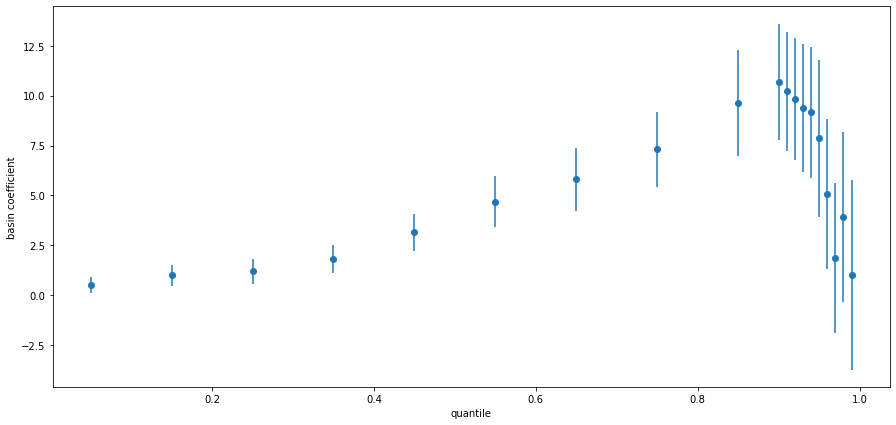

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(models['quantile'], models['basin'])
plt.errorbar(models['quantile'], models['basin'],
             yerr=models['BASINci'], linestyle="None")
ax.set_xlabel('quantile', fontsize=10)
ax.set_ylabel('basin coefficient', fontsize=10)

In [20]:
def myplot(q, q2, q3, title):
    fig, ax = plt.subplots(figsize=(15, 10))
    x_val = TP

    ax.plot([x_val[0], x_val[1]], [minq[q, 2], maxq[q, 2]],
            color='green', linestyle='dotted')
    ax.plot([x_val[0], x_val[1]], [minq[q, 3], maxq[q, 3]],
            color='green', linestyle='dotted')
    plt.fill_between([x_val[0], x_val[1]], [minq[q, 2], maxq[q, 2]], [minq[q, 3], maxq[q, 3]],
                     color='green',       # The outline color
                     alpha=0.2)          # Transparency of the fill

    ax.plot([x_val[0], x_val[1]], [minq[q2, 2], maxq[q2, 2]],
            color='orange', linestyle='dotted')
    ax.plot([x_val[0], x_val[1]], [minq[q2, 3], maxq[q2, 3]],
            color='orange', linestyle='dotted')
    plt.fill_between([x_val[0], x_val[1]], [minq[q2, 2], maxq[q2, 2]], [minq[q2, 3], maxq[q2, 3]],
                     color='orange',       # The outline color
                     alpha=0.2)          # Transparency of the fill
    ax.plot([x_val[0], x_val[1]], [minq[q3, 2], maxq[q3, 2]],
            color='blue', linestyle='dotted')
    ax.plot([x_val[0], x_val[1]], [minq[q3, 3], maxq[q3, 3]],
            color='blue', linestyle='dotted')
    plt.fill_between([x_val[0], x_val[1]], [minq[q3, 2], maxq[q3, 2]], [minq[q3, 3], maxq[q3, 3]],
                     color='blue',       # The outline color
                     alpha=0.2)          # Transparency of the fill

    ax.scatter(data.TP, data.CA, alpha=.2)
    ax.set_xlim((0, 0.35))
    ax.set_ylim((0, 130))
    ax.set_xlabel('TP', fontsize=16)
    ax.set_ylabel('CA', fontsize=16)
    ax.set_title(title, fontsize=16)

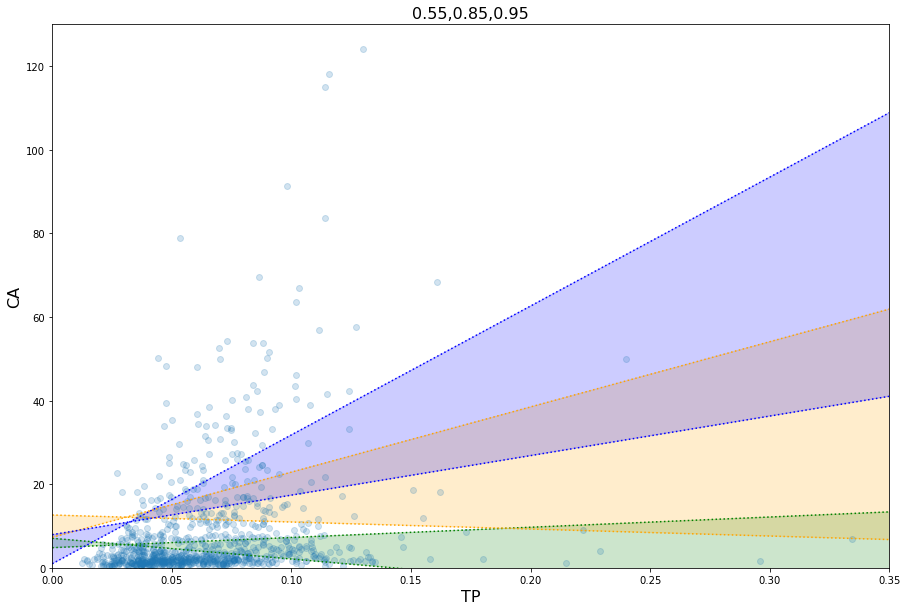

In [21]:
myplot(5, 9, 14, '0.55,0.85,0.95')

In [22]:
# 3-d plots
######################################## Data preparation #########################################
df = df[['TP', 'RM', 'CA']]
df = df.dropna()
X = df[['TP', 'RM']].values.reshape(-1, 2)
Y = df['CA']
# SETTING UP X VARIABLES, MIN AND MAX OF EACH
TP = [0, 0.35]
RM = [0, 80]

# 3
i = 9
z1 = models.loc[i, 'TP']*TP[0] + models.loc[i, 'basin']*BASIN[0] + models.loc[i, 'TN'] * \
    TN[0] + models.loc[i, 'prcpavg_73']*PRCP[0] + \
    models.loc[i, 'tavg_57']*TEMP[0] + intercept
z2 = models.loc[i, 'TP']*TP[0] + models.loc[i, 'basin']*BASIN[1] + models.loc[i, 'TN'] * \
    TN[1] + models.loc[i, 'prcpavg_73']*PRCP[1] + \
    models.loc[i, 'tavg_57']*TEMP[1] + intercept
z3 = models.loc[i, 'TP']*TP[1] + models.loc[i, 'basin']*BASIN[0] + models.loc[i, 'TN'] * \
    TN[1] + models.loc[i, 'prcpavg_73']*PRCP[1] + \
    models.loc[i, 'tavg_57']*TEMP[1] + intercept
z4 = models.loc[i, 'TP']*TP[1] + models.loc[i, 'basin']*BASIN[1] + models.loc[i, 'TN'] * \
    TN[0] + models.loc[i, 'prcpavg_73']*PRCP[0] + \
    models.loc[i, 'tavg_57']*TEMP[0] + intercept


x = TP
y = RM

X, Y = np.meshgrid(x, y)
Z = np.array([[z1, z2], [z3, z4]])

# print(X)
# print(Y)
# print(Z)

In [23]:
# rotate the axes and update
#for angle in range(0, 360):
#    fig = plt.figure(figsize=(10, 4))
#    ax = plt.axes(projection='3d')
#    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                cmap='Paired', edgecolor='none',alpha=0.5)
#    ax.set_title('0.95 quantile regression CA ~ 1 + TP + TN + basin + tavg_57 + prcpavg_73 ');
#    ax.scatter(df.TP, df.RM, df.CA, linewidth=0.5)

#    ax.set_xlabel('TP')
#    ax.set_ylabel('River Mile (used basin in model (0/1))')
#    ax.set_zlabel('CA');
#    ax.view_init(30, angle)
#    fig.tight_layout()
#    fig.savefig('gif_image%d.png' % angle)


In [24]:
#for angle in np.arange(0, 360,90):
#    fig = plt.figure(figsize=(10, 4))
#    ax = plt.axes(projection='3d')
#    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                cmap='Paired', edgecolor='none',alpha=0.5)
#    ax.set_title('0.95 quantile regression CA ~ 1 + TP + TN + basin + tavg_57 + prcpavg_73 ');
#    ax.scatter(df.TP, df.RM, df.CA, linewidth=0.5)

#    ax.set_xlabel('TP')
#    ax.set_ylabel('River Mile (used basin in model (0/1))')
#    ax.set_zlabel('CA');
#    ax.view_init(30, angle)
#    fig.tight_layout()
    
    

# Multiple Quantile Regression- without total nitrogen


In [25]:
mod = smf.quantreg('CA ~ 1 + TP  + basin + tavg_57 + prcpavg_73 ', data)
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85,
             0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
print('Quantiles = ', quantiles)

Quantiles =  [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [26]:
def fit_model(q):
    res = mod.fit(q=q)
    ci = res.conf_int(alpha=0.005)
    return [q, res.params['Intercept'], res.params['TP'], res.params['tavg_57'], res.params['prcpavg_73'], res.params['basin']]

In [27]:
models_1 = [fit_model(x) for x in quantiles]
models_1 = pd.DataFrame(models, columns=[
                        'quantile', 'intercept', 'TP', 'tavg_57', 'prcpavg_73', 'basin'])
models_1

C:\Users\rdeterman\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


,quantile,intercept,TP,tavg_57,prcpavg_73,basin
0,0.05,0.486546,4.925831,0.007948,-0.285816,0.499872
1,0.15,0.525110,9.674340,0.040047,-0.601535,1.014320
2,0.25,0.633552,12.174869,0.061517,-0.754840,1.206900
3,0.35,0.929927,11.363191,0.083250,-0.760854,1.829815
4,0.45,1.511682,11.191659,0.118210,-1.178234,3.151423
5,0.55,2.554093,9.097272,0.209965,-1.847579,4.675051
6,0.65,3.095928,17.772008,0.272913,-2.275574,5.803419
7,0.75,3.480661,36.986511,0.369880,-2.577244,7.305300
8,0.85,4.318780,72.177930,0.584012,-3.232729,9.646679
9,0.90,3.574211,115.665287,0.736026,-3.743294,10.696968


In [28]:
# SETTING UP X VARIABLES, MIN AND MAX OF EACH
TP = [0, 0.50]
PRCP = [-2, 4, 0.6]
TEMP = [-1.5, 2.5]
BASIN = [0, 1]


citp = np.empty([np.shape(quantiles)[0]])
ciprcp = np.empty([np.shape(quantiles)[0]])
citemp = np.empty([np.shape(quantiles)[0]])
cibasin = np.empty([np.shape(quantiles)[0]])

# ALLOCATES ENOUGH ROWS FOR THE REGRESSION COEFFICIENTS AT EACH QUANTILE
row = (np.shape(quantiles)[0])

# CREATES ARRAY FOR MINIMUM VALUE OF COEFFICIENTS FROM THE PROVIDED X VARIABLES
minq = np.zeros([row, 4])
maxq = np.zeros([row, 4])  # CREATES ARRAY FOR MAXIMUM VALUE OF COEFFICIENTS


for i in np.arange(0, np.shape(quantiles)[0]):  # for each quantile
    res = mod.fit(q=quantiles[i])  # create a fit at quantile i
    # find the confidence interval based on the res fit
    ci = res.conf_int(alpha=0.005)

    cTP = ci.loc['TP', 1]
    xTP = res.params['TP']
    citp[i] = cTP-xTP

    cPRCP = ci.loc['prcpavg_73', 1]
    xPRCP = res.params['prcpavg_73']
    ciprcp[i] = cPRCP-xPRCP

    cTEMP = ci.loc['tavg_57', 1]
    xTEMP = res.params['tavg_57']
    citemp[i] = cTEMP-xTEMP

    cBASIN = ci.loc['basin', 1]
    xBASIN = res.params['basin']
    cibasin[i] = cBASIN-xBASIN

    # find the intercept based on the res fit
    intercept = np.array(res.params['Intercept'])

    # 0 = quantile; 1 = y-value; 2 = upper ci y value; 3 = lower ci y value
    minq[i][0] = i
    minq[i][1] = models_1.loc[i, 'TP']*TP[0] + models_1.loc[i, 'prcpavg_73']*PRCP[0] + \
        models_1.loc[i, 'tavg_57']*TEMP[0] + \
        models_1.loc[i, 'basin']*BASIN[0] + intercept
    minq[i][2] = ci.loc['TP', 0]*TP[0] + ci.loc['prcpavg_73', 0]*PRCP[0] + \
        ci.loc['tavg_57', 0]*TEMP[0] + ci.loc['basin', 0]*BASIN[0] + intercept
    minq[i][3] = ci.loc['TP', 1]*TP[0] + ci.loc['prcpavg_73', 1]*PRCP[0] + \
        ci.loc['tavg_57', 1]*TEMP[0] + ci.loc['basin', 1]*BASIN[0] + intercept

    maxq[i][0] = i
    maxq[i][1] = models_1.loc[i, 'TP']*TP[1] + models_1.loc[i, 'prcpavg_73']*PRCP[1] + \
        models_1.loc[i, 'tavg_57']*TEMP[1] + \
        models_1.loc[i, 'basin']*BASIN[1] + intercept
    maxq[i][2] = ci.loc['TP', 0]*TP[1] + ci.loc['prcpavg_73', 0]*PRCP[1] + \
        ci.loc['tavg_57', 0]*TEMP[1]+ci.loc['basin', 0]*BASIN[1] + intercept
    maxq[i][3] = ci.loc['TP', 1]*TP[1] + ci.loc['prcpavg_73', 1]*PRCP[1] + \
        ci.loc['tavg_57', 1]*TEMP[1]+ci.loc['basin', 1]*BASIN[1] + intercept

C:\Users\rdeterman\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


In [29]:
models_1.insert(3, 'TPci', citp)
models_1.insert(5, 'TEMPci', citemp)
models_1.insert(7, 'PRCPci', ciprcp)
models_1.insert(9, 'BASINci', cibasin)

In [30]:
models_1

,quantile,intercept,TP,TPci,tavg_57,TEMPci,prcpavg_73,PRCPci,basin,BASINci
0,0.05,0.486546,4.925831,5.725121,0.007948,0.023431,-0.285816,0.126727,0.499872,0.384927
1,0.15,0.525110,9.674340,7.853866,0.040047,0.029423,-0.601535,0.182779,1.014320,0.506594
2,0.25,0.633552,12.174869,8.795398,0.061517,0.034531,-0.754840,0.216895,1.206900,0.600140
3,0.35,0.929927,11.363191,10.456136,0.083250,0.038117,-0.760854,0.251561,1.829815,0.672666
4,0.45,1.511682,11.191659,12.929860,0.118210,0.049639,-1.178234,0.343343,3.151423,0.888640
5,0.55,2.554093,9.097272,16.882599,0.209965,0.067003,-1.847579,0.494582,4.675051,1.230605
6,0.65,3.095928,17.772008,19.609617,0.272913,0.080105,-2.275574,0.635537,5.803419,1.513275
7,0.75,3.480661,36.986511,23.375133,0.369880,0.095871,-2.577244,0.814566,7.305300,1.862477
8,0.85,4.318780,72.177930,31.738510,0.584012,0.128698,-3.232729,1.124978,9.646679,2.568527
9,0.90,3.574211,115.665287,35.111465,0.736026,0.145057,-3.743294,1.332887,10.696968,2.999841


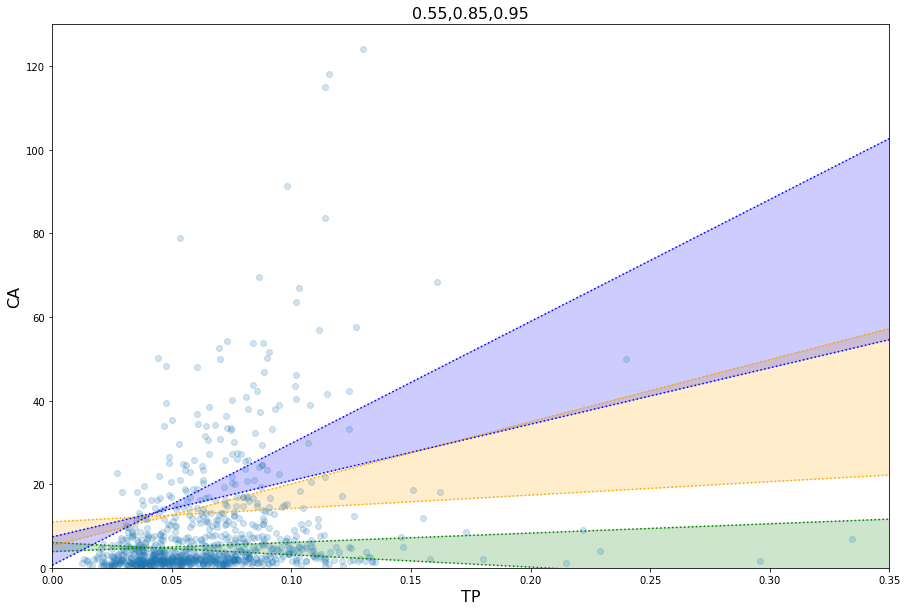

In [31]:
myplot(5,9,14,'0.55,0.85,0.95')